In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0288 - val_loss: 0.0027
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0019

🔍 Gerando gráfico para PETR4.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


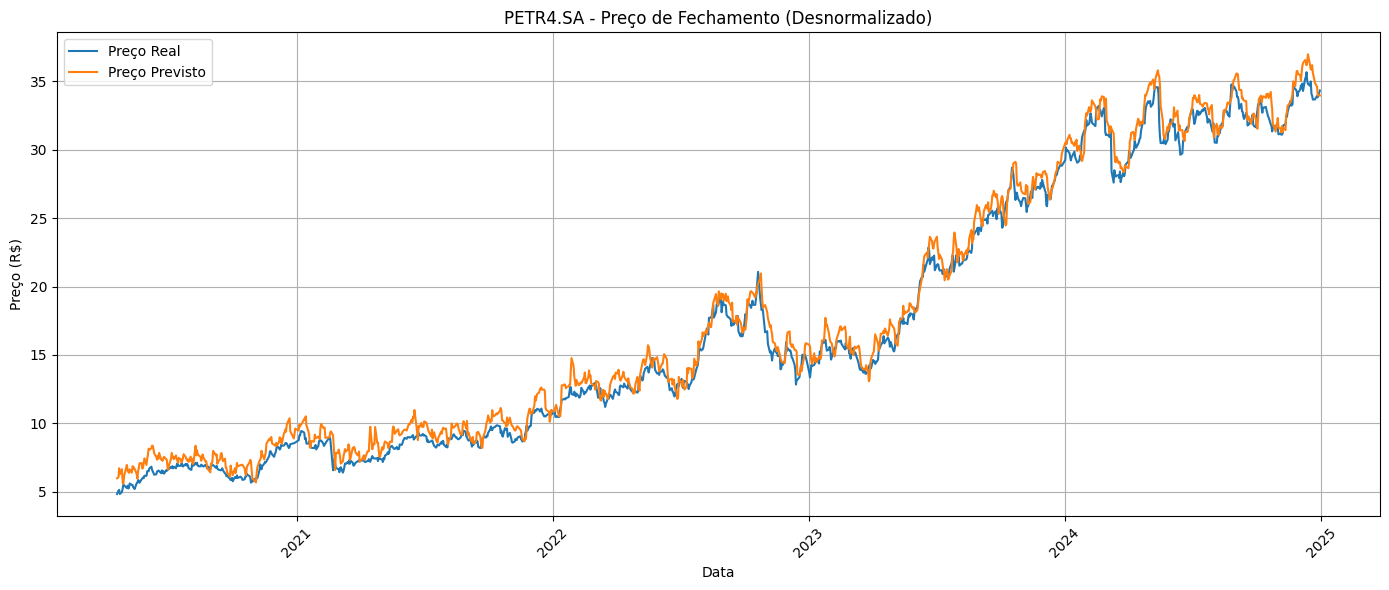


🔍 Gerando gráfico para VALE3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


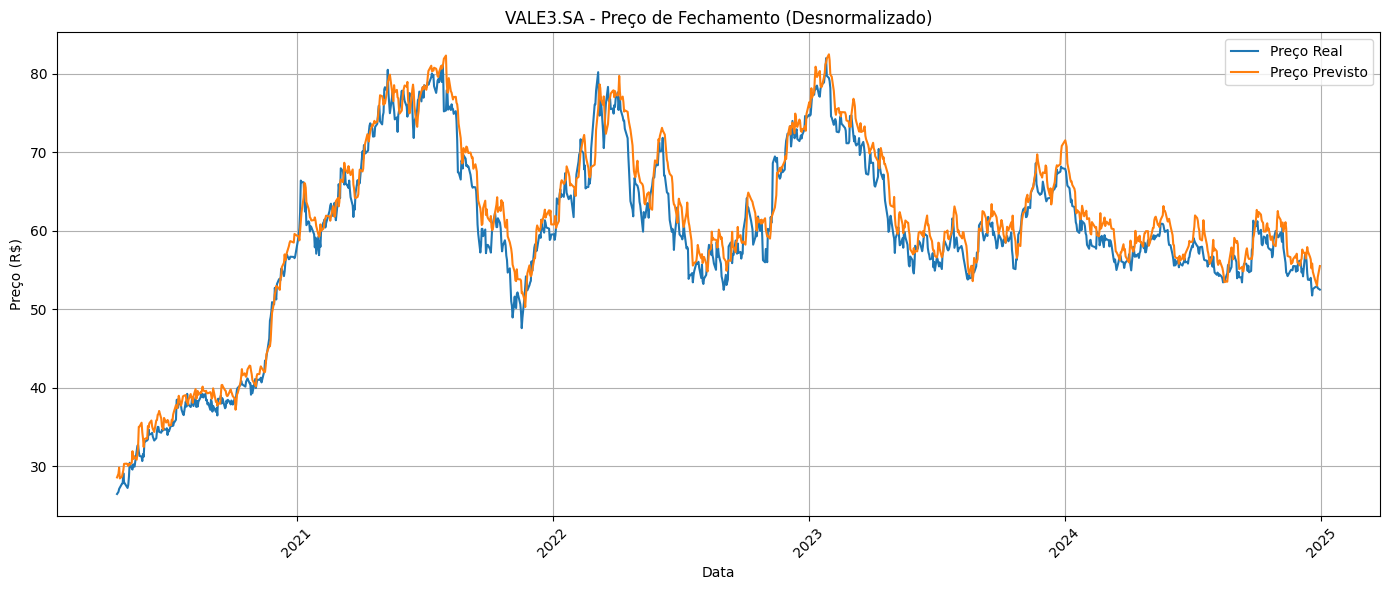


🔍 Gerando gráfico para ITUB4.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


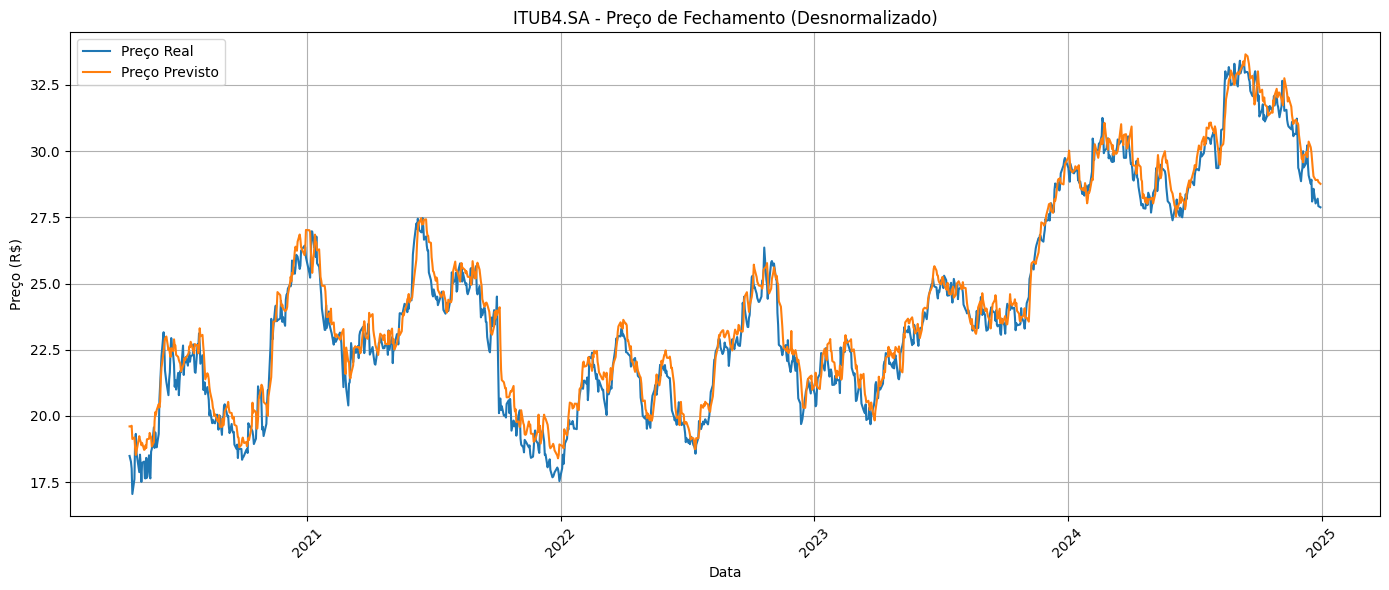


🔍 Gerando gráfico para B3SA3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


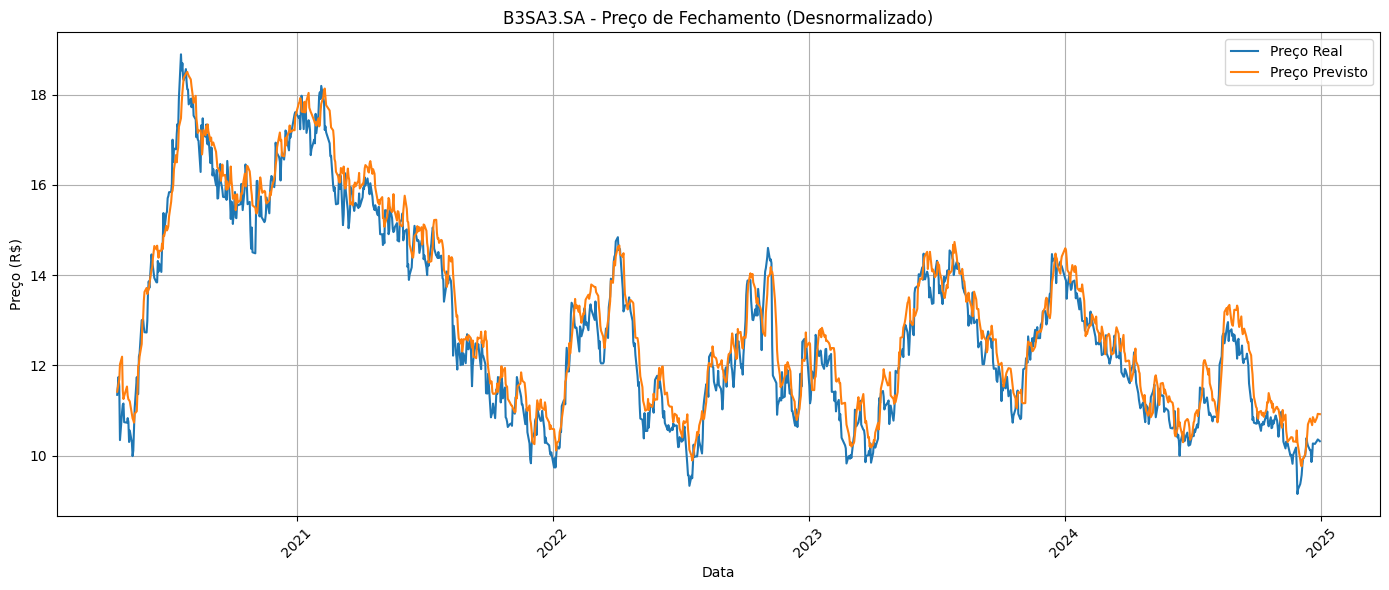


🔍 Gerando gráfico para ABEV3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


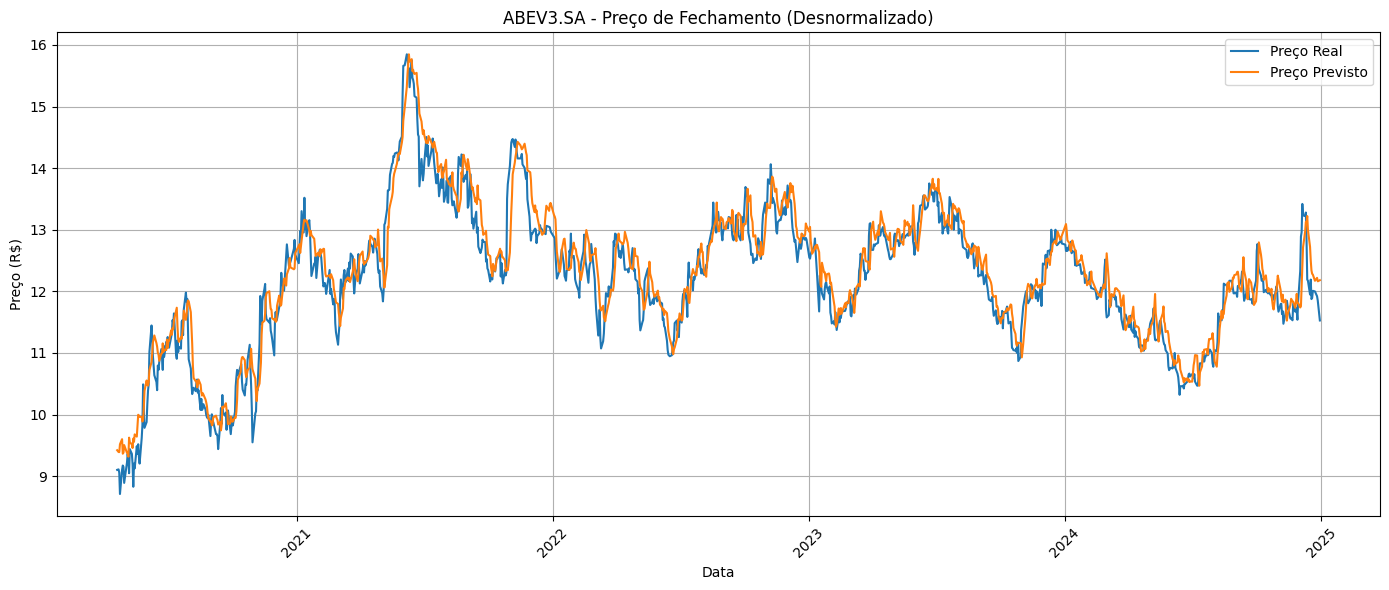

In [ ]:
# Lista de ações brasileiras
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "B3SA3.SA", "ABEV3.SA"]

start_date = "2020-01-01"
end_date = "2024-12-31"
window_size = 60

# Indicadores técnicos
def add_technical_indicators(df):
    close = df['Close'].squeeze()
    df['SMA'] = close.rolling(window=10).mean()
    df['EMA'] = close.ewm(span=10).mean()
    delta = close.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=close.index).rolling(14).mean()
    avg_loss = pd.Series(loss, index=close.index).rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df = df.dropna()
    return df

# Sequências
def create_sequences(data, dates, window_size=60):
    X, y, y_dates = [], [], []
    for i in range(window_size, len(data) - 1):
        X.append(data[i-window_size:i])
        y.append(data[i+1, 0])
        y_dates.append(dates[i+1])
    return np.array(X), np.array(y), y_dates

# Armazenar dados
X_total, y_total = [], []
scalers = {}
data_por_acao = {}

for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if df.empty:
        continue
    df = add_technical_indicators(df)
    features = df[['Close', 'SMA', 'EMA', 'RSI']].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)

    # Criar sequências
    X, y, y_dates = create_sequences(scaled, df.index, window_size)
    X_total.append(X)
    y_total.append(y)
    scalers[ticker] = scaler
    data_por_acao[ticker] = {
        'X': X,
        'y': y,
        'dates': y_dates,
        'original': df  # salvar DataFrame original
    }

# Juntar todos os dados para treino do modelo
X_combined = np.concatenate(X_total)
y_combined = np.concatenate(y_total)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, shuffle=False)

# Construir o modelo CNN
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_combined.shape[1], X_combined.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Previsão e gráfico por ação
for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n🔍 Gerando gráfico para {ticker}...")
    X = data_por_acao[ticker]['X']
    y = data_por_acao[ticker]['y']
    dates = data_por_acao[ticker]['dates']
    scaler = scalers[ticker]

    # Previsões normalizadas
    y_pred = model.predict(X)

    # Desnormalizar
    real_prices = scaler.inverse_transform(np.column_stack((y, np.zeros((len(y), 3)))))[:, 0]
    predicted_prices = scaler.inverse_transform(np.column_stack((y_pred.reshape(-1), np.zeros((len(y), 3)))))[:, 0]

    # Gráfico
    plt.figure(figsize=(14, 6))
    plt.plot(dates, real_prices, label="Preço Real")
    plt.plot(dates, predicted_prices, label="Preço Previsto")
    plt.title(f"{ticker} - Preço de Fechamento (Desnormalizado)")
    plt.xlabel("Data")
    plt.ylabel("Preço (R$)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


📈 Previsão futura para PETR4.SA até 2025-06-06...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/st

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0543945af6a>:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


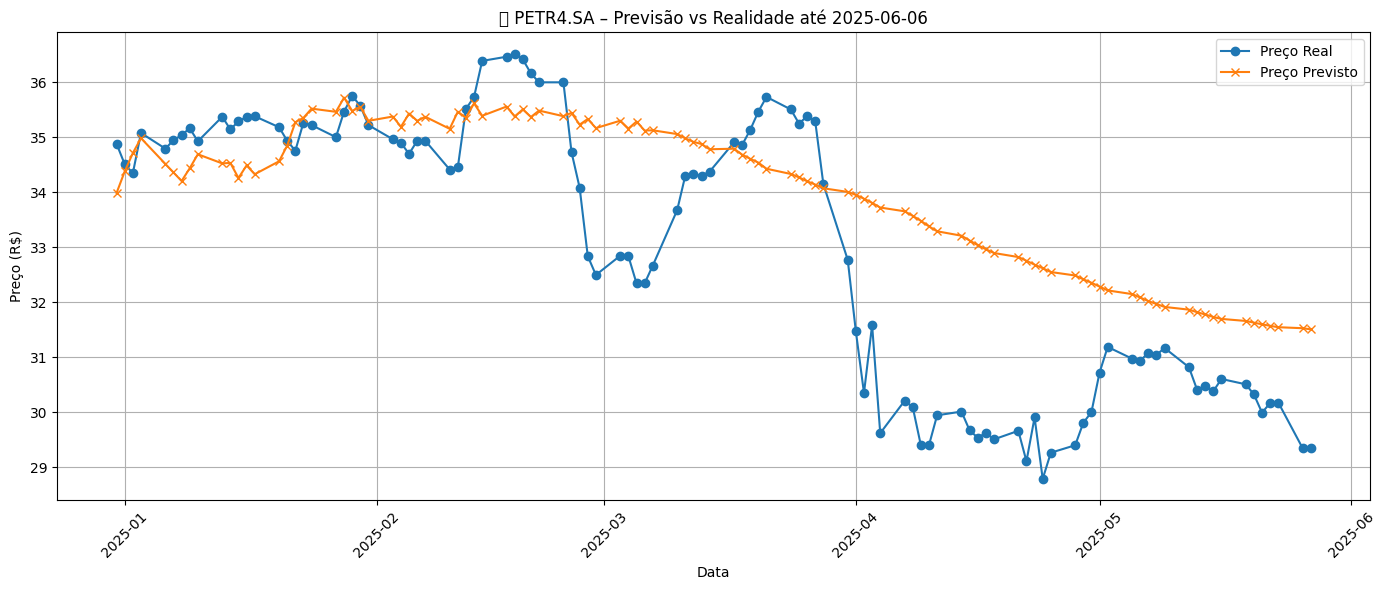


📈 Previsão futura para VALE3.SA até 2025-06-06...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0543945af6a>:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


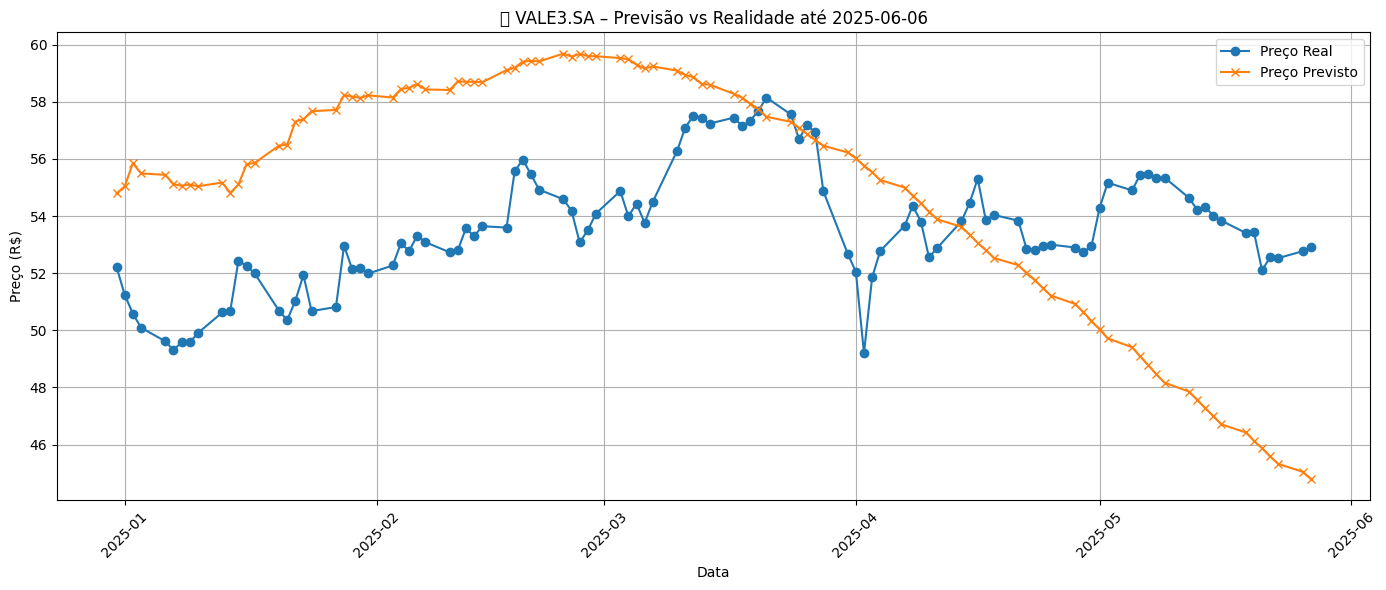


📈 Previsão futura para ITUB4.SA até 2025-06-06...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0543945af6a>:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


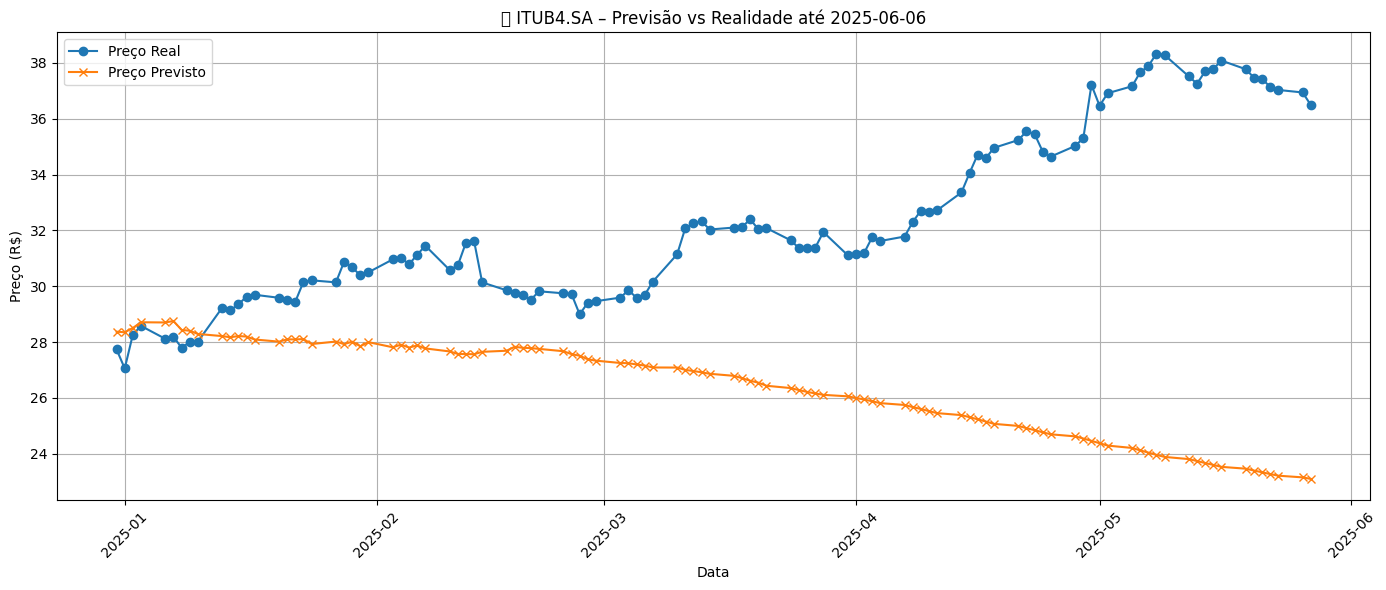


📈 Previsão futura para B3SA3.SA até 2025-06-06...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0543945af6a>:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


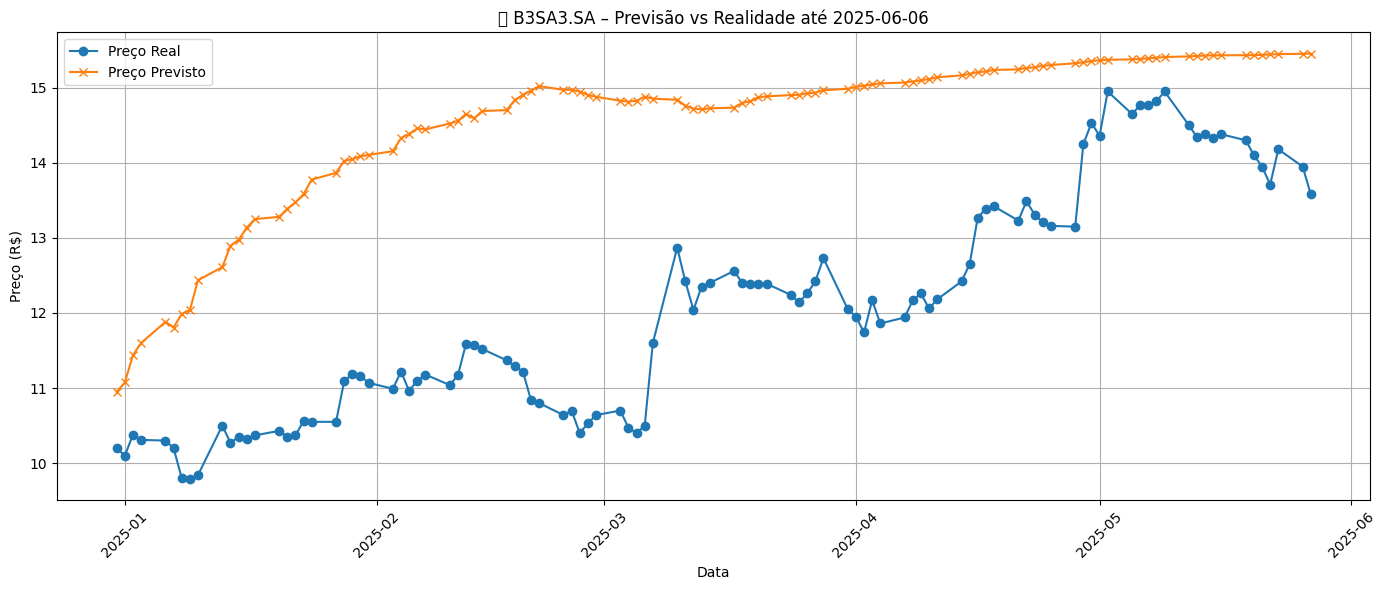


📈 Previsão futura para ABEV3.SA até 2025-06-06...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c0543945af6a>:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


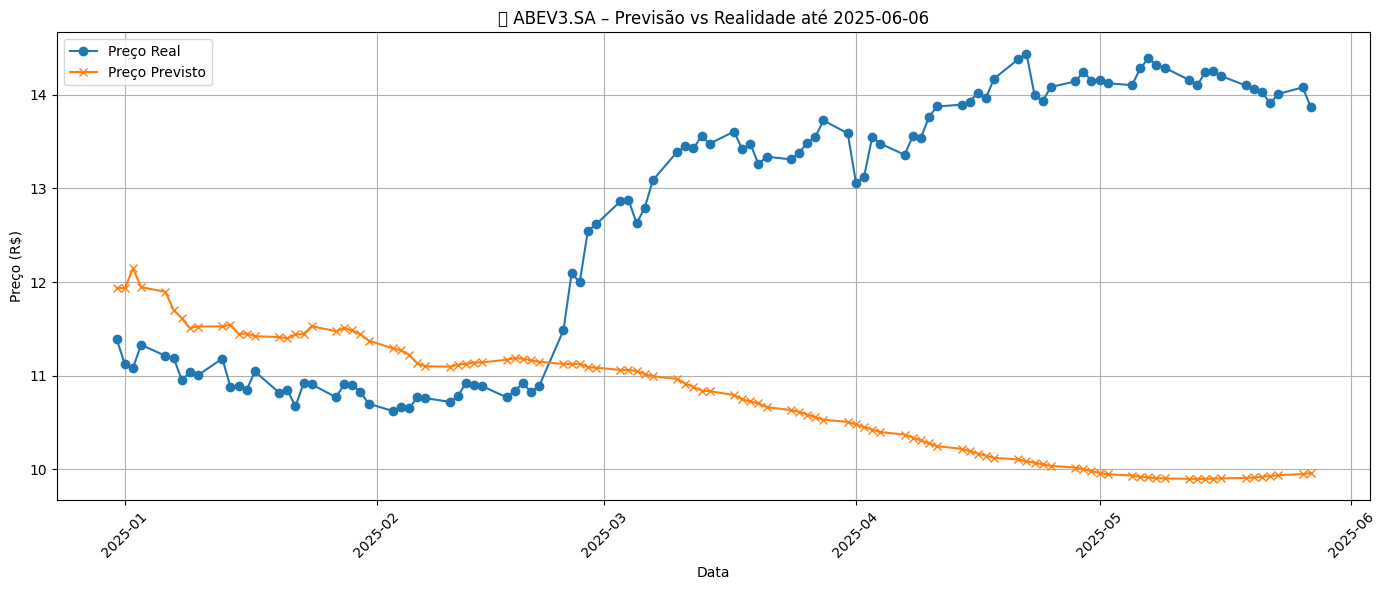

In [ ]:
from datetime import datetime, timedelta

# Prever do último ponto conhecido até hoje
today = datetime.today().date()

for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n📈 Previsão futura para {ticker} até {today}...")

    # Dados existentes
    df = data_por_acao[ticker]['original'].copy()
    last_date = df.index[-1].date()

    if last_date >= today:
        print("  🔹 Já atualizado até hoje.")
        continue

    scaler = scalers[ticker]
    last_window = df[['Close', 'SMA', 'EMA', 'RSI']].values[-window_size:]
    scaled_window = scaler.transform(last_window)

    future_dates = []
    predicted_prices = []

    current_window = scaled_window.copy()

    # Previsões até hoje
    while last_date < today:
        X_input = np.expand_dims(current_window, axis=0)  # (1, 60, 4)
        next_scaled_close = model.predict(X_input)[0][0]

        # Desnormaliza
        next_row = scaler.inverse_transform([[next_scaled_close, 0, 0, 0]])[0]
        predicted_prices.append(next_row[0])

        # Avança um dia
        next_features = current_window[-1].copy()
        next_features[0] = next_scaled_close
        current_window = np.vstack([current_window[1:], next_features])

        last_date += timedelta(days=1)
        while last_date.weekday() > 4:  # pular fins de semana
            last_date += timedelta(days=1)
        future_dates.append(last_date)

    # Obter os preços reais no mesmo período
    real_df = yf.download(ticker, start=future_dates[0], end=today + timedelta(days=1))
    real_df = real_df[real_df['Close'].notna()]

    real_dates = real_df.index.date
    real_prices = real_df['Close'].values

    # Alinhar tamanhos (às vezes dias úteis não batem exatamente)
    min_len = min(len(predicted_prices), len(real_prices))
    aligned_dates = future_dates[:min_len]
    predicted_prices = predicted_prices[:min_len]
    real_prices = real_prices[:min_len]

    # Gráfico
    plt.figure(figsize=(14, 6))
    plt.plot(aligned_dates, real_prices, label="Preço Real", marker='o')
    plt.plot(aligned_dates, predicted_prices, label="Preço Previsto", marker='x')
    plt.title(f"📊 {ticker} – Previsão vs Realidade até {today}")
    plt.xlabel("Data")
    plt.ylabel("Preço (R$)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Comparação de erros por ação
for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n📊 Avaliação de erro para {ticker}...")

    # Recuperar dados
    y = data_por_acao[ticker]['y'] # preços reais normalizados
    X = data_por_acao[ticker]['X']
    scaler = scalers[ticker]

    # Previsões normalizadas
    y_pred_scaled = model.predict(X)

    # Desnormalizar y (real) e y_pred (previsto)
    # Precisamos desnormalizar apenas a coluna 'Close' que é a primeira (índice 0)
    # y está como (n,), precisamos remodelar para (n, 1) para usar inverse_transform
    real_prices_eval = scaler.inverse_transform(np.column_stack((y.reshape(-1, 1), np.zeros((len(y), 3)))))[:, 0]
    predicted_prices_eval = scaler.inverse_transform(np.column_stack((y_pred_scaled.reshape(-1, 1), np.zeros((len(y), 3)))))[:, 0]

    # Calcular métricas de erro
    mae = mean_absolute_error(real_prices_eval, predicted_prices_eval)
    mse = mean_squared_error(real_prices_eval, predicted_prices_eval)
    rmse = np.sqrt(mse)

    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")

# Comparação de erros para a previsão futura (do último ponto até hoje)
print("\n📊 Avaliação de erro para previsão futura (último ponto até hoje)...")

for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n  Ticker: {ticker}")

    # Recuperar dados da previsão futura (calculados no código anterior)
    # Precisamos garantir que future_dates, predicted_prices e real_prices
    # estejam acessíveis aqui ou recalculá-los para este ticker

    # Para simplificar, vamos refazer o cálculo dos real_prices no período de previsão futura
    today = datetime.today().date()
    df = data_por_acao[ticker]['original'].copy()
    last_date = df.index[-1].date()

    if last_date >= today:
        print("  🔹 Já atualizado até hoje. Nenhuma previsão futura para avaliar.")
        continue

    future_dates = []
    predicted_prices_future = [] # Armazenar previsões futuras

    # Replicar a lógica de previsão futura para obter predicted_prices_future
    scaler = scalers[ticker]
    last_window = df[['Close', 'SMA', 'EMA', 'RSI']].values[-window_size:]
    scaled_window = scaler.transform(last_window)
    current_window = scaled_window.copy()
    current_date = last_date # Usar uma variável separada para iterar datas futuras

    while current_date < today:
        X_input = np.expand_dims(current_window, axis=0)
        next_scaled_close = model.predict(X_input)[0][0]
        next_row = scaler.inverse_transform([[next_scaled_close, 0, 0, 0]])[0]
        predicted_prices_future.append(next_row[0])

        current_date += timedelta(days=1)
        while current_date.weekday() > 4:
            current_date += timedelta(days=1)
        future_dates.append(current_date)

    # Obter os preços reais no mesmo período
    real_df_future = yf.download(ticker, start=future_dates[0], end=today + timedelta(days=1))
    real_df_future = real_df_future[real_df_future['Close'].notna()]

    real_dates_future = real_df_future.index.date
    real_prices_future = real_df_future['Close'].values

    # Alinhar tamanhos
    min_len_future = min(len(predicted_prices_future), len(real_prices_future))
    aligned_predicted_future = predicted_prices_future[:min_len_future]
    aligned_real_future = real_prices_future[:min_len_future]

    if min_len_future > 0:
        # Calcular métricas de erro para a previsão futura
        mae_future = mean_absolute_error(aligned_real_future, aligned_predicted_future)
        mse_future = mean_squared_error(aligned_real_future, aligned_predicted_future)
        rmse_future = np.sqrt(mse_future)

        print(f"    MAE: {mae_future:.4f}")
        print(f"    MSE: {mse_future:.4f}")
        print(f"    RMSE: {rmse_future:.4f}")
    else:
        print("    Nenhum dado real disponível no período de previsão futura para avaliação.")


📊 Avaliação de erro para PETR4.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  MAE: 0.7919
  MSE: 0.9299
  RMSE: 0.9643

📊 Avaliação de erro para VALE3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  MAE: 1.9274
  MSE: 5.8079
  RMSE: 2.4100

📊 Avaliação de erro para ITUB4.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  MAE: 0.5363
  MSE: 0.4645
  RMSE: 0.6815

📊 Avaliação de erro para B3SA3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  MAE: 0.4172
  MSE: 0.2612
  RMSE: 0.5110

📊 Avaliação de erro para ABEV3.SA...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  MAE: 0.2632
  MSE: 0.1176
  RMSE: 0.3430

📊 Avaliação de erro para previsão futura (último ponto até hoje)...

  Ticker: PETR4.SA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 2.2065
    MSE: 6.9211
    RMSE: 2.6308

  Ticker: VALE3.SA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 2.0144
    MSE: 5.9070
    RMSE: 2.4304

  Ticker: ITUB4.SA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 3.9517
    MSE: 24.5405
    RMSE: 4.9538

  Ticker: B3SA3.SA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 1.4273
    MSE: 3.4105
    RMSE: 1.8468

  Ticker: ABEV3.SA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 1.4626
    MSE: 2.4656
    RMSE: 1.5702


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from datetime import datetime, timedelta # Necessário para a seção de previsão futura

# Comparação de erros por ação (dados históricos)
print("\n📊 Avaliação de erro para dados históricos por ação...")
for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n  Ticker: {ticker} (Histórico)")

    # Recuperar dados
    y = data_por_acao[ticker]['y'] # preços reais normalizados
    X = data_por_acao[ticker]['X']
    scaler = scalers[ticker]

    # Previsões normalizadas
    y_pred_scaled = model.predict(X)

    # Desnormalizar y (real) e y_pred (previsto)
    # Precisamos desnormalizar apenas a coluna 'Close' que é a primeira (índice 0)
    # y está como (n,), precisamos remodelar para (n, 1) para usar inverse_transform
    real_prices_eval = scaler.inverse_transform(np.column_stack((y.reshape(-1, 1), np.zeros((len(y), 3)))))[:, 0]
    predicted_prices_eval = scaler.inverse_transform(np.column_stack((y_pred_scaled.reshape(-1, 1), np.zeros((len(y), 3)))))[:, 0]

    # Calcular métricas de erro
    mae = mean_absolute_error(real_prices_eval, predicted_prices_eval)
    mse = mean_squared_error(real_prices_eval, predicted_prices_eval)
    rmse = np.sqrt(mse)

    print(f"    MAE: {mae:.4f}")
    print(f"    MSE: {mse:.4f}")
    print(f"    RMSE: {rmse:.4f}")

# Comparação de erros para a previsão futura (do último ponto até hoje)
print("\n📊 Avaliação de erro para previsão futura (último ponto até hoje) por ação...")

for ticker in tickers:
    if ticker not in data_por_acao:
        continue

    print(f"\n  Ticker: {ticker} (Previsão Futura)")

    # Recuperar dados da previsão futura (calculados no código anterior)
    # Precisamos garantir que future_dates, predicted_prices e real_prices
    # estejam acessíveis aqui ou recalculá-los para este ticker

    # Para simplificar, vamos refazer o cálculo dos real_prices no período de previsão futura
    today = datetime.today().date()
    df = data_por_acao[ticker]['original'].copy()
    last_date = df.index[-1].date()

    if last_date >= today:
        print("    🔹 Já atualizado até hoje. Nenhuma previsão futura para avaliar.")
        continue

    future_dates = []
    predicted_prices_future = [] # Armazenar previsões futuras

    # Replicar a lógica de previsão futura para obter predicted_prices_future
    scaler = scalers[ticker]
    last_window = df[['Close', 'SMA', 'EMA', 'RSI']].values[-window_size:]
    scaled_window = scaler.transform(last_window)
    current_window = scaled_window.copy()
    current_date = last_date # Usar uma variável separada para iterar datas futuras

    while current_date < today:
        X_input = np.expand_dims(current_window, axis=0)
        next_scaled_close = model.predict(X_input)[0][0]
        next_row = scaler.inverse_transform([[next_scaled_close, 0, 0, 0]])[0]
        predicted_prices_future.append(next_row[0])

        current_date += timedelta(days=1)
        while current_date.weekday() > 4:
            current_date += timedelta(days=1)
        future_dates.append(current_date)

    # Obter os preços reais no mesmo período
    real_df_future = yf.download(ticker, start=future_dates[0], end=today + timedelta(days=1))
    real_df_future = real_df_future[real_df_future['Close'].notna()]

    real_dates_future = real_df_future.index.date
    real_prices_future = real_df_future['Close'].values

    # Alinhar tamanhos
    min_len_future = min(len(predicted_prices_future), len(real_prices_future))
    aligned_predicted_future = predicted_prices_future[:min_len_future]
    aligned_real_future = real_prices_future[:min_len_future]

    if min_len_future > 0:
        # Calcular métricas de erro para a previsão futura
        mae_future = mean_absolute_error(aligned_real_future, aligned_predicted_future)
        mse_future = mean_squared_error(aligned_real_future, aligned_predicted_future)
        rmse_future = np.sqrt(mse_future)

        print(f"    MAE: {mae_future:.4f}")
        print(f"    MSE: {mse_future:.4f}")
        print(f"    RMSE: {rmse_future:.4f}")
    else:
        print("    Nenhum dado real disponível no período de previsão futura para avaliação.")


📊 Avaliação de erro para dados históricos por ação...

  Ticker: PETR4.SA (Histórico)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
    MAE: 0.7919
    MSE: 0.9299
    RMSE: 0.9643

  Ticker: VALE3.SA (Histórico)
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
    MAE: 1.9274
    MSE: 5.8079
    RMSE: 2.4100

  Ticker: ITUB4.SA (Histórico)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
    MAE: 0.5363
    MSE: 0.4645
    RMSE: 0.6815

  Ticker: B3SA3.SA (Histórico)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
    MAE: 0.4172
    MSE: 0.2612
    RMSE: 0.5110

  Ticker: ABEV3.SA (Histórico)
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
    MAE: 0.2632
    MSE: 0.1176
    RMSE: 0.3430

📊 Avaliação de erro para previsão futura (último ponto até hoje) por ação...

  Ticker: PETR4.SA (Previsão Futura)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[*********************100%***********************]  1 of 1 completed

    MAE: 2.1931
    MSE: 6.9020
    RMSE: 2.6272

  Ticker: VALE3.SA (Previsão Futura)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 2.0144
    MSE: 5.9070
    RMSE: 2.4304

  Ticker: ITUB4.SA (Previsão Futura)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 3.7810
    MSE: 23.9428
    RMSE: 4.8931

  Ticker: B3SA3.SA (Previsão Futura)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 1.4273
    MSE: 3.4105
    RMSE: 1.8468

  Ticker: ABEV3.SA (Previsão Futura)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed

    MAE: 1.4626
    MSE: 2.4656
    RMSE: 1.5702
